## Task 1: Graph Cut Segmentation

**Instructions:**

- Given 2 images (asm-1, asm2), generate a bounding box for a person in each images by utilizing any deep learning-based object detectors (pretrain model).
- Leveraging the generated bounding boxes, implement graph-based image segmentation using OpenCV function, `cv2.grabCut`.
- Run GrabCut for 1, 3, and 5 iterations — report qualitative and quantitative differences.
- Visualize Results: Display original images, user masks, and final segmentation results (foreground only, and overlay).

**Deliverable:**

- Jupyter notebook with clear code and comments.

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
import pandas as pd
from typing import Dict

In [33]:
def detect_person_for_grabcut(IMAGE_PATH, model):
    
    img_cv2 = cv2.imread(IMAGE_PATH)
    if img_cv2 is None:
        print(f"Could not read image: {IMAGE_PATH}")
        return None, None
        
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    results = model(img_rgb)

    result = results[0]
    person_bbox_xyxy = None
    person_bbox_xywh = None # For grabCut

    # Loop through detected objects
    for box in result.boxes:
        class_id = int(box.cls[0])

        if class_id == 0: #person class
            
            person_bbox_xyxy = list(map(int, box.xyxy[0]))
            
            # grabCut format
            x1, y1, x2, y2 = person_bbox_xyxy
            w = x2 - x1
            h = y2 - y1
            person_bbox_xywh = (x1, y1, w, h)
            
            print(f"Processing: {IMAGE_PATH}")
            print(f"Found person with confidence score: {box.conf[0]:.2f}")
            print(f"-> YOLO coordinates (x1, y1, x2, y2): {person_bbox_xyxy}")
            print(f"-> Rectangle for GrabCut (x, y, w, h): {person_bbox_xywh}")
            
            break 

    if person_bbox_xyxy:
        x1, y1, x2, y2 = person_bbox_xyxy
      
        img_with_box = cv2.rectangle(img_rgb.copy(), (x1, y1), (x2, y2), (255, 0, 0), 3) 
        
        plt.figure(figsize=(8, 8))
        plt.imshow(img_with_box)
        plt.title(f'Detected person ({IMAGE_PATH})')
        plt.axis('off')
        plt.show()
        
    else:
        print(f"No person detected on given image ({IMAGE_PATH})")
        
    return img_cv2, person_bbox_xywh


0: 448x640 1 person, 1 bicycle, 4.1ms
Speed: 0.8ms preprocess, 4.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Processing: asm-1.jpg
Found person with confidence score: 0.90
-> YOLO coordinates (x1, y1, x2, y2): [261, 64, 352, 301]
-> Rectangle for GrabCut (x, y, w, h): (261, 64, 91, 237)


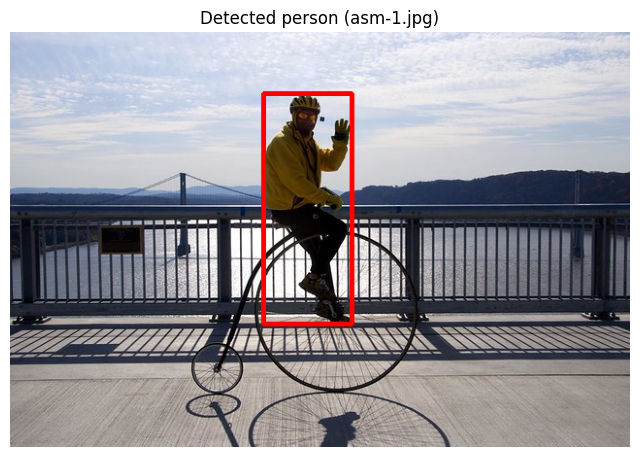


0: 448x640 1 person, 1 skateboard, 4.2ms
Speed: 0.7ms preprocess, 4.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Processing: asm-2.jpg
Found person with confidence score: 0.90
-> YOLO coordinates (x1, y1, x2, y2): [192, 35, 450, 270]
-> Rectangle for GrabCut (x, y, w, h): (192, 35, 258, 235)


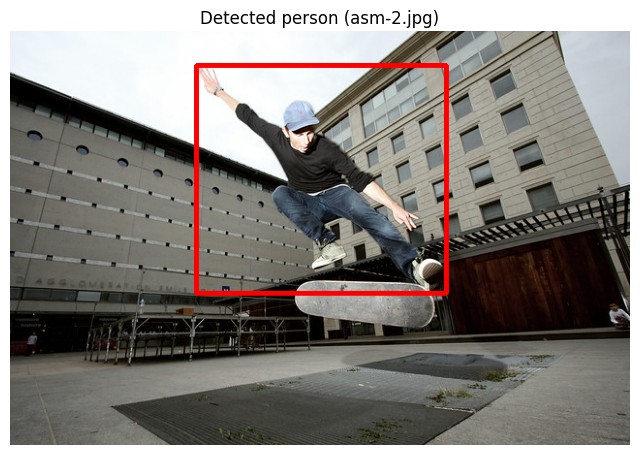

In [34]:
model = YOLO('yolov8n.pt')

IMAGE_PATH_1 = 'asm-1.jpg' 
asm_1, bbox_1 = detect_person_for_grabcut(IMAGE_PATH_1, model)

IMAGE_PATH_2 = 'asm-2.jpg' 
asm_2, bbox_2 = detect_person_for_grabcut(IMAGE_PATH_2, model)

In [35]:
def run_and_plot_grabcut(image, bbox, iterations, image_name_str):
    """
    Runs GrabCut on an image given a bounding box and plots all required results.
    Returns the final binary mask for quantitative comparison.
    """
    
    if image is None or bbox is None:
        print(f"ERROR: Skipping {image_name_str} (Image or Bbox not provided).")
        return None
        
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = bbox

    #Based on given bbox from detection model, grabCut knows that pixels outside bbox are definitely foreground.
    #Within the background he checks if pixels are more similar to background, and creates an object segmentation mask.
    #The process is repeated iteratively, so that the mask can be improved.
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_RECT)

    # Create a new binary mask where 1 = foreground
    mask_result = np.where((mask == cv2.GC_PR_FGD) | (mask == cv2.GC_FGD), 1, 0).astype('uint8')

    img_original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get foreground only by multiplying image with the mask
    img_foreground = image * mask_result[:, :, np.newaxis]
    img_foreground_rgb = cv2.cvtColor(img_foreground, cv2.COLOR_BGR2RGB)
    
    # Create overlay (dim the background)
    img_overlay_rgb = img_original_rgb.copy()
    # Apply a dimming effect (e.g., 60% darker) to background pixels
    img_overlay_rgb[mask_result == 0] = (img_overlay_rgb[mask_result == 0] * 0.4).astype(np.uint8)

    plt.figure(figsize=(20, 5))
    plt.suptitle(f'Results for {image_name_str} ({iterations} Iterations)', fontsize=16)

    plt.subplot(1, 4, 1)
    plt.imshow(img_original_rgb)
    plt.title('1. Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask_result, cmap='gray')
    plt.title('2. Final Mask')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(img_foreground_rgb)
    plt.title('3. Foreground Only')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(img_overlay_rgb)
    plt.title('4. Overlay')
    plt.axis('off')

    plt.show()
    return mask_result

--- STARTING ANALYSIS FOR IMAGE 1: asm-1.jpg ---


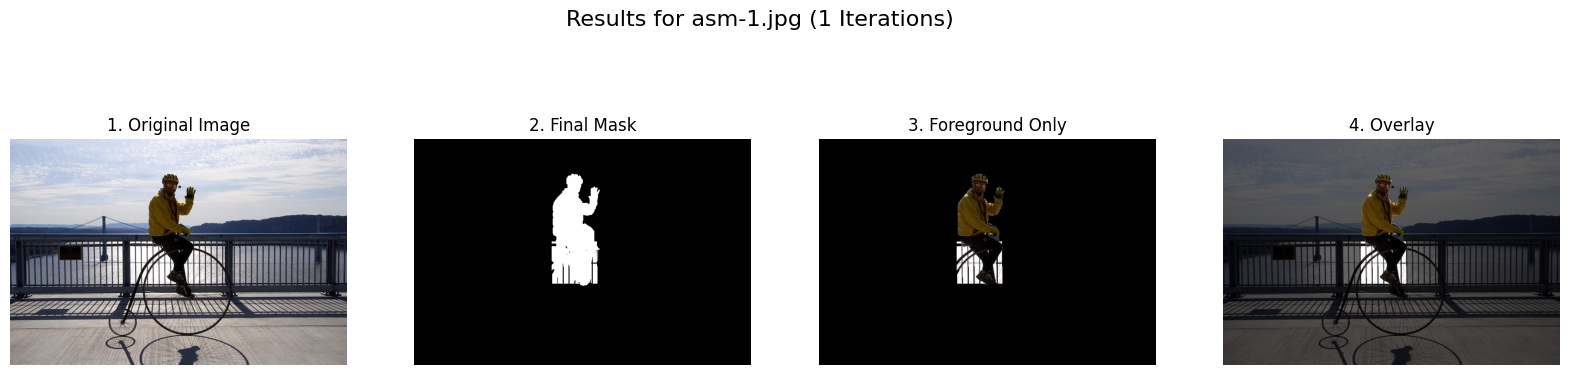

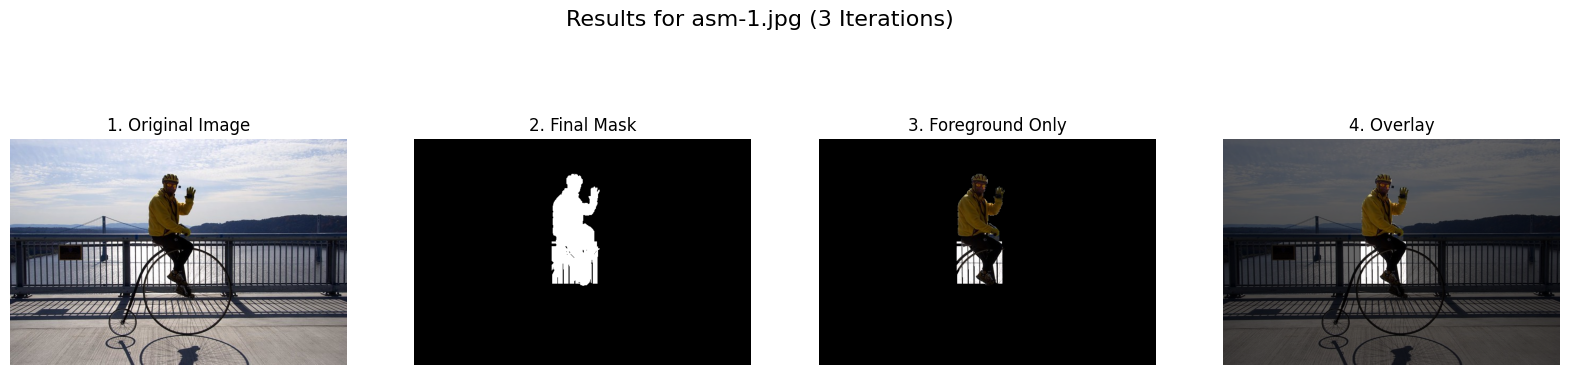

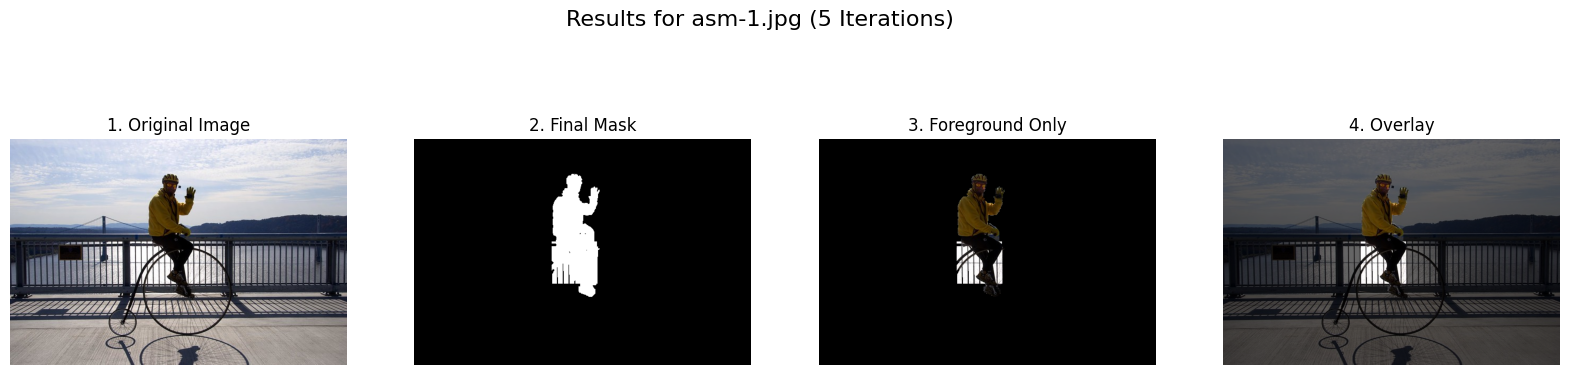


--- STARTING ANALYSIS FOR IMAGE 2: asm-2.jpg ---


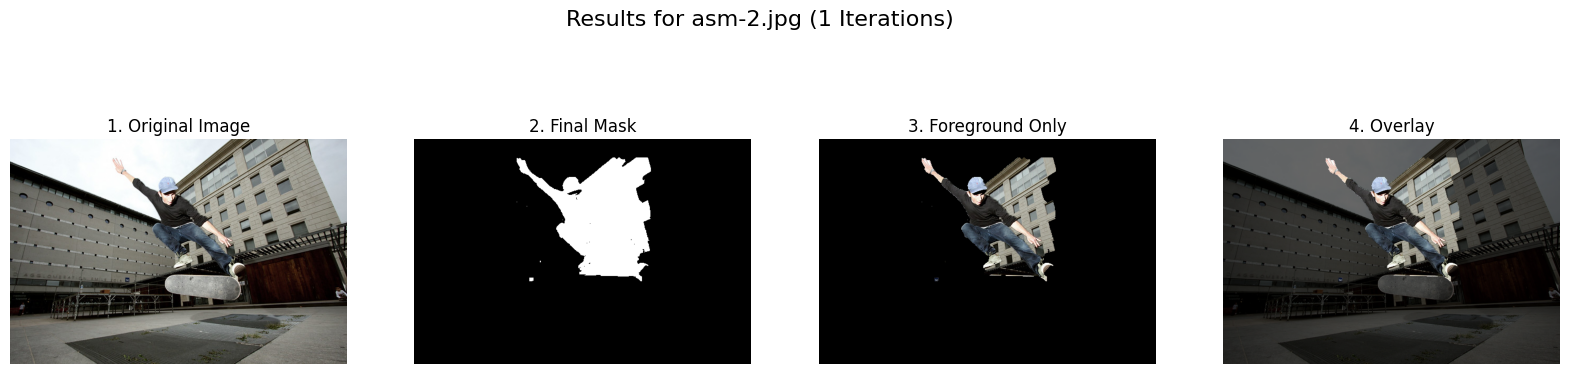

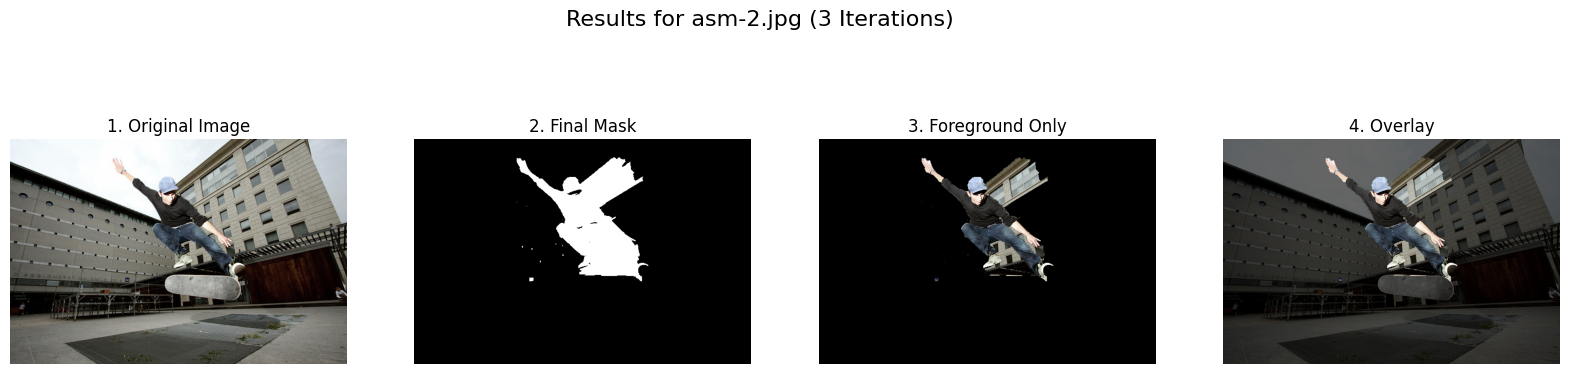

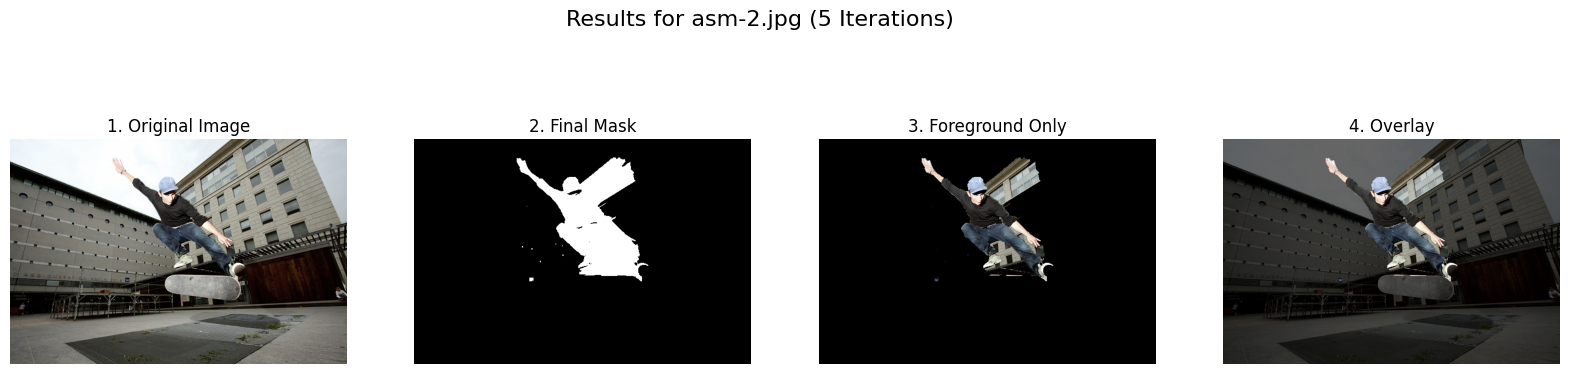

In [36]:
iterations_to_run = [1, 3, 5]

print(f"--- STARTING ANALYSIS FOR IMAGE 1: {IMAGE_PATH_1} ---")
masks_image_1 = {} 

if 'asm_1' in locals() and 'bbox_1' in locals():
    for iters in iterations_to_run:
        mask = run_and_plot_grabcut(asm_1, bbox_1, iters, IMAGE_PATH_1)
        if mask is not None:
            masks_image_1[iters] = mask
else:
    print(f"Skipping Image 1, variables 'image_1' or 'bbox_1' not found.")

print(f"\n--- STARTING ANALYSIS FOR IMAGE 2: {IMAGE_PATH_2} ---")
masks_image_2 = {} # Store masks for image 2

if 'asm_2' in locals() and 'bbox_2' in locals():
    for iters in iterations_to_run:
        mask = run_and_plot_grabcut(asm_2, bbox_2, iters, IMAGE_PATH_2)
        if mask is not None:
            masks_image_2[iters] = mask
else:
    print(f"Skipping Image 2, variables 'image_2' or 'bbox_2' not found.")

For the image1 i don't see much difference between 1, 3 and 5 iterations. Person mask looks the same to me. Unfortunateluy the algorithm was not able to get rid of the railing that is behind the person.

For the image2 there is a big improvement between 1 and 3 iterations. Algorithm cut out big part of the building from behind the person. Unfortunately the mask stilll includes a window even after 5 iterations, so the mask is not perfect.

In [ ]:
def generate_iteration_statistics_table(masks_dict: Dict[int, np.ndarray], image_name: str) -> pd.DataFrame:
    """
    Generates a DataFrame showing pixel count statistics (FG/BG ratio) for each GrabCut iteration.
    """
    if not masks_dict:
        print(f"Skipping statistics for {image_name}: Mask dictionary is empty.")
        return pd.DataFrame()

    data = []
    
    for iters in sorted(masks_dict.keys()):
        mask = masks_dict.get(iters)
        if mask is None:
            continue
            
        total_pixels = mask.size
        fg_pixels = np.sum(mask) 
        bg_pixels = total_pixels - fg_pixels
        
        fg_ratio = (fg_pixels / total_pixels) * 100
        
        data.append({
            'Iteration Count': iters,
            'Total Pixels': total_pixels,
            'Foreground Pixels': fg_pixels,
            'Background Pixels': bg_pixels,
            'FG Ratio (%)': f'{fg_ratio:.2f}' # Formatowanie do dwóch miejsc po przecinku
        })

    df = pd.DataFrame(data)
    
    return df

In [38]:
print("\n--- Quantitative Analysis: Image 1 ---")
df_asm1 = generate_iteration_statistics_table(masks_image_1, 'asm-1.jpg')
display(df_asm1.style.hide(axis='index'))

print("\n--- Quantitative Analysis: Image 2 ---")
df_asm2 = generate_iteration_statistics_table(masks_image_2, 'asm-2.jpg')
display(df_asm2.style.hide(axis='index'))


--- Quantitative Analysis: Image 1 ---


Iteration Count,Total Pixels,Foreground Pixels,Background Pixels,FG Ratio (%)
1,273492,14070,259422,5.14
3,273492,14103,259389,5.16
5,273492,14766,258726,5.40



--- Quantitative Analysis: Image 2 ---


Iteration Count,Total Pixels,Foreground Pixels,Background Pixels,FG Ratio (%)
1,273280,31989,241291,11.71
3,273280,24251,249029,8.87
5,273280,23638,249642,8.65


For Image 1 we can see that the mask didn't change much comparing 1 and 3 iterations. After 5 iterations we can see that the masks incorporates more pixels. However the Foreground Ration is almost the same for all iterations, which confirms my previous qualitative conculsions.

For Image 2 we see significant mask improvement after 3 iterations - the Foreground ratio decresed by almost 3%, making the mask more adequate. However we don't see big further improvement after 5 iterations.